# Exercise 11

The purpose of this exercise is to develop as accurate as possible RNN (recurrent neural network) model that predicts electricity consumption in a property. 

Prediction:
1. Predict the next hour electricity consumption
2. Predict the next day (24h) electricity consumption 

The data set shows the hourly consumption of the property for the period from 1 January 2017 to 28 February 2022. The files are named as year-month.csv i.e. 2022-2.csv includes consumption from February 2022. Note: the timestamp 1.1.2017 00:00 is the electricity consumption from 1.1.2017 00:00 to 01:00. 

Zipped dataset file can be found from the Moodle: Electricity_consumption.zip

Dataset splitting:
1. Training dataset: 1.1.2017-30.9.2020
2. Test dataset: 1.10.2020-30.9.2021
3. "Another test dataset", which is used to when your RNN is ready: 1.10.2021-28.2.2022 


Enrich data using open data from (Finnish meteorological Institute)[https://en.ilmatieteenlaitos.fi/]. 
- The weather station location is: Jyväskylä lentoasema, 137208, longitude: 62.39, latitude: 25.69
- Enriched dataset have to contain AT LEAST the temperature, but you can use other information such as windy, humidity etc.


In [4]:
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error
import math



In [46]:
# Training dataset: 1.1.2017-30.9.2020
# Test dataset: 1.10.2020-30.9.2021
# "Another test dataset", which is used to when your RNN is ready: 1.10.2021-28.2.2022

# prepared the data on another workbook, as colab could not handle the data cleaning same way as Jupyter
# and in the local environment I had this issue https://github.com/tensorflow/models/issues/9706

df_train = pd.read_csv('data/df_11_train.csv', parse_dates = ['Datetime'], index_col = ['Datetime'])
df_test = pd.read_csv('data/df_11_test.csv', parse_dates = ['Datetime'], index_col = ['Datetime'])
df_test2 = pd.read_csv('data/df_11_test2.csv', parse_dates = ['Datetime'], index_col = ['Datetime'])

df_test

,Power,Precipitation amount (mm),Air temperature (degC),Wind speed (m/s)
Datetime,,,,
2020-10-01 00:00:00,0.32,0.0,9.8,0.0
2020-10-01 01:00:00,0.68,0.0,9.4,0.8
2020-10-01 02:00:00,0.31,0.0,9.3,0.0
2020-10-01 03:00:00,0.41,0.0,9.4,1.0
2020-10-01 04:00:00,2.04,0.0,9.5,0.0
...,...,...,...,...
2021-09-30 19:00:00,1.81,0.0,6.6,2.3
2021-09-30 20:00:00,3.95,0.0,6.6,2.3
2021-09-30 21:00:00,1.99,0.0,6.4,1.8


In [47]:
print(f'{df_train.shape} ja {1369 * 24}')
print(f'{df_test.shape} ja {365 * 24}')
print(f'{df_test2.shape} ja {151 * 24}')

(32855, 4) ja 32856
(8760, 4) ja 8760
(3625, 4) ja 3624


In [48]:
def split_to_features_and_target(data):
    y = data[['Power']].copy()
    X = data.drop(['Power'], axis = 1).copy()
    return X, y

X_train, y_train = split_to_features_and_target(df_train)
X_test, y_test = split_to_features_and_target(df_test)
X_test2, y_test2 = split_to_features_and_target(df_test2)

# Scaling

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test2_scaled = scaler.transform(X_test2)

scalero = MinMaxScaler()
scalero.fit(y_train)
y_train_scaled = scalero.transform(y_train)
y_test_scaled = scalero.transform(y_test)
y_test2_scaled = scalero.transform(y_test2)

In [15]:
X_train_scaled

array([[0.        , 0.71359223, 0.        ],
       [0.        , 0.69579288, 0.04697987],
       [0.        , 0.70064725, 0.        ],
       ...,
       [0.        , 0.64724919, 0.0738255 ],
       [0.        , 0.63754045, 0.04697987],
       [0.        , 0.63754045, 0.06711409]])

In [ ]:
#  Let's start to build the next hour electricity consumption prediction

In [49]:
# Stepify gotten from Satu Korhonen! Modified to suit my data and to stepify also y.
def stepify(data):
    lookback = 72 # hours to look back
    X=[]

    for i in range(len(data) - lookback - 1):
        t=[]
        for j in range(0, lookback):
            t.append(data[[(i + j)], :])
        X.append(t)
        
    X = np.array(X)
    X = X.reshape(X.shape[0], lookback, data.shape[1]) # data.shape[1] is used for getting no of features/targets
    print(X.shape)
    return X

X_train_scaled_steps = stepify(X_train_scaled)
X_test_scaled_steps = stepify(X_test_scaled)
X_test2_scaled_steps = stepify(X_test2_scaled)

y_train_scaled_steps = stepify(y_train_scaled)
y_test_scaled_steps = stepify(y_test_scaled)
y_test2_scaled_steps = stepify(y_test2_scaled)



(32782, 72, 3)
(8687, 72, 3)
(3552, 72, 3)
(32782, 72, 1)
(8687, 72, 1)
(3552, 72, 1)


In [50]:
print(X_train_scaled_steps)

[[[0.         0.5264     0.32885906]
  [0.         0.5216     0.27516779]
  [0.         0.5184     0.27516779]
  ...
  [0.01360544 0.3008     0.37583893]
  [0.         0.2944     0.3557047 ]
  [0.         0.288      0.34899329]]

 [[0.         0.5216     0.27516779]
  [0.         0.5184     0.27516779]
  [0.         0.512      0.32214765]
  ...
  [0.         0.2944     0.3557047 ]
  [0.         0.288      0.34899329]
  [0.         0.2816     0.26845638]]

 [[0.         0.5184     0.27516779]
  [0.         0.512      0.32214765]
  [0.         0.5024     0.29530201]
  ...
  [0.         0.288      0.34899329]
  [0.         0.2816     0.26845638]
  [0.         0.2688     0.2885906 ]]

 ...

 [[0.         0.6368     0.03355705]
  [0.         0.6128     0.04026846]
  [0.         0.6112     0.05369128]
  ...
  [0.         0.6704     0.0738255 ]
  [0.         0.6704     0.0738255 ]
  [0.         0.6672     0.10067114]]

 [[0.         0.6128     0.04026846]
  [0.         0.6112     0.05369128]


In [51]:
# Predict the next hour electricity consumption

input_layer = tf.keras.Input(shape=(72,3))
rnn = tf.keras.layers.SimpleRNN(72)(input_layer)
output = tf.keras.layers.Dense(1)(rnn)
rnn_model = tf.keras.Model(inputs = input_layer,
                           outputs = output)

rnn_model.compile(optimizer = 'adam',
                   loss = 'mse',
                   metrics = ['mean_squared_error'])

rnn_model.fit(X_train_scaled_steps, y_train_scaled_steps, epochs=10, verbose=1)



Epoch 1/10
1025/1025 [==============================] - 25s 23ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 2/10
1025/1025 [==============================] - 24s 23ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 3/10
1025/1025 [==============================] - 23s 23ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 4/10
1025/1025 [==============================] - 23s 23ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 5/10
1025/1025 [==============================] - 23s 23ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 6/10
1025/1025 [==============================] - 24s 23ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 7/10
1025/1025 [==============================] - 24s 23ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 8/10
1025/1025 [==============================] - 23s 23ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 9/10
1025/1025 [==============================] - 24s 23ms/step - loss: 0.0112 - m

In [52]:
test_results = rnn_model.evaluate(X_test_scaled_steps, y_test_scaled_steps, verbose=0)
predictions = rnn_model.predict(X_test_scaled_steps)
print(f"Test loss {test_results[0]}")

test_results2 = rnn_model.evaluate(X_test2_scaled_steps, y_test2_scaled_steps, verbose=0)
predictions2 = rnn_model.predict(X_test2_scaled_steps)
print(f"Test2 loss {test_results2[0]}")

Test loss 0.01179254071694157
Test2 loss 0.014556735963770398


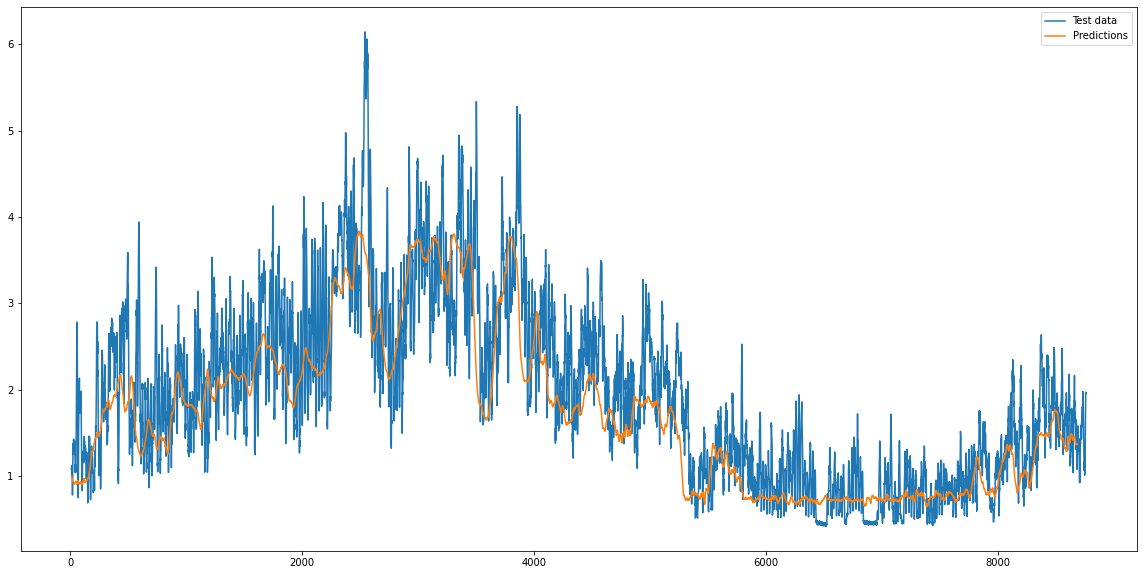

In [70]:
from IPython.display import Image

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(pd.DataFrame(scalero.inverse_transform(y_test_scaled)).rolling(10).mean(), label = 'Test data')
ax.plot(pd.DataFrame(scalero.inverse_transform(predictions)).rolling(10).mean(), label='Predictions')
plt.legend()
plt.show()




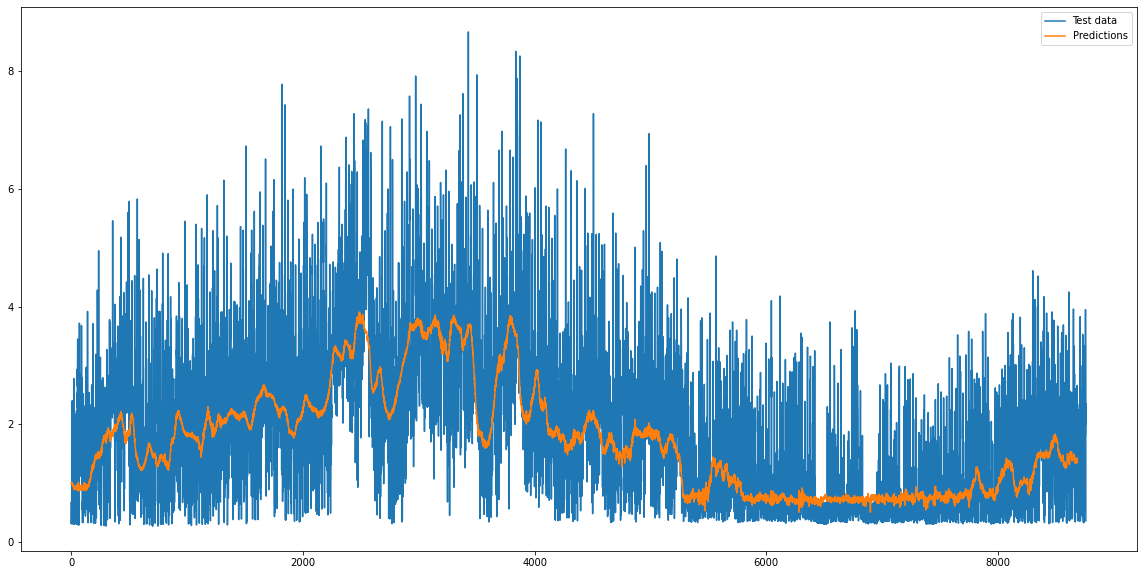

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(pd.DataFrame(scalero.inverse_transform(y_test_scaled)), label = 'Test data')
ax.plot(pd.DataFrame(scalero.inverse_transform(predictions)), label='Predictions')
# plt.xlim(100, 200) # for checking if it looks cyclic (sin)
plt.legend()
plt.show()

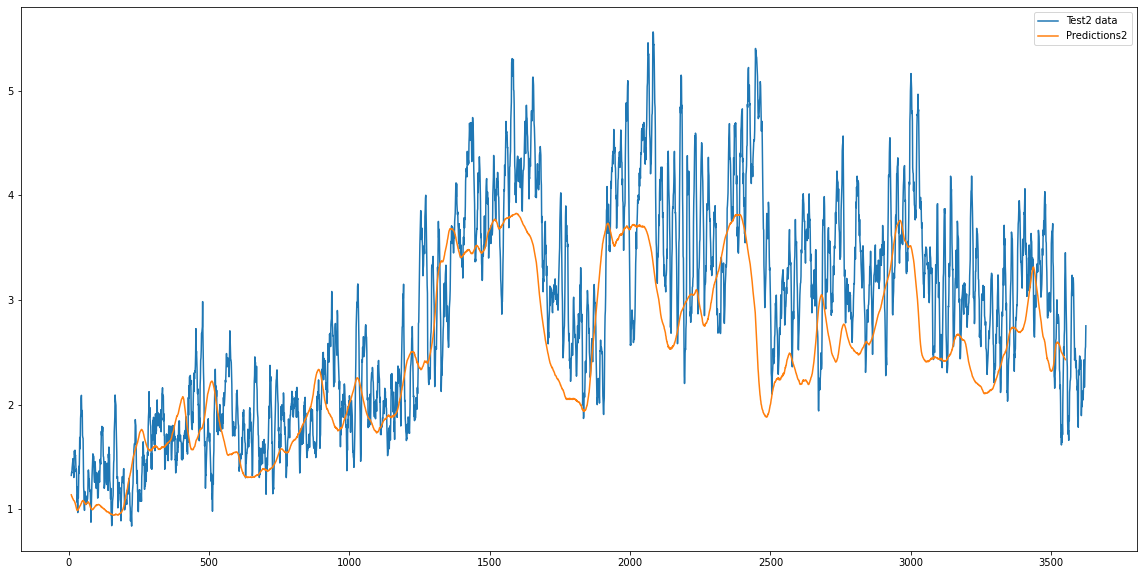

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(pd.DataFrame(scalero.inverse_transform(y_test2_scaled)).rolling(10).mean(), label = 'Test2 data')
ax.plot(pd.DataFrame(scalero.inverse_transform(predictions2)).rolling(10).mean(), label='Predictions2')
plt.legend()
plt.show()

In [ ]:
# Predict the next day (24h) electricity consumption

In [74]:
def stepify(data):
    lookback = 168 # hours to look back
    n_ahead = 24 # steps ahead to forecast

    X=[]

    for i in range(len(data) - lookback - n_ahead):
        t=[]
        for j in range(0, lookback):
            t.append(data[[(i + j)], :])
        X.append(t)
        
    X = np.array(X)
    X = X.reshape(X.shape[0], lookback, data.shape[1]) # data.shape[1] is used for getting no of features/targets
    print(X.shape)
    return X

X_train_scaled_steps_24 = stepify(X_train_scaled)
X_test_scaled_steps_24 = stepify(X_test_scaled)
X_test2_scaled_steps_24 = stepify(X_test2_scaled)

y_train_scaled_steps_24 = stepify(y_train_scaled)
y_test_scaled_steps_24 = stepify(y_test_scaled)
y_test2_scaled_steps_24 = stepify(y_test2_scaled)

(32663, 168, 3)
(8568, 168, 3)
(3433, 168, 3)
(32663, 168, 1)
(8568, 168, 1)
(3433, 168, 1)


In [75]:
input_layer = tf.keras.Input(shape=(168,3))
rnn = tf.keras.layers.SimpleRNN(168)(input_layer)
output = tf.keras.layers.Dense(1)(rnn)
rnn_model_24 = tf.keras.Model(inputs = input_layer,
                           outputs = output)

rnn_model_24.compile(optimizer = 'adam',
                   loss = 'mse',
                   metrics = ['mean_squared_error'])

rnn_model_24.fit(X_train_scaled_steps_24, y_train_scaled_steps_24, epochs=10, verbose=1)

Epoch 1/10
1021/1021 [==============================] - 134s 130ms/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 2/10
1021/1021 [==============================] - 137s 134ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 3/10
1021/1021 [==============================] - 133s 130ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 4/10
1021/1021 [==============================] - 132s 130ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 5/10
1021/1021 [==============================] - 131s 128ms/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 6/10
1021/1021 [==============================] - 137s 134ms/step - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 7/10
1021/1021 [==============================] - 136s 133ms/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 8/10
1021/1021 [==============================] - 136s 134ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 9/10
1021/1021 [==============================] - 136s 133ms/step 

In [76]:
test_results_24 = rnn_model_24.evaluate(X_test_scaled_steps_24, y_test_scaled_steps_24, verbose=0)
predictions_24 = rnn_model_24.predict(X_test_scaled_steps_24)
print(f"Test loss {test_results_24[0]}")

test_results2_24 = rnn_model_24.evaluate(X_test2_scaled_steps_24, y_test2_scaled_steps_24, verbose=0)
predictions2_24 = rnn_model_24.predict(X_test2_scaled_steps_24)
print(f"Test2 loss {test_results2_24[0]}")

Test loss 0.01248766976059958
Test2 loss 0.016646845514720326


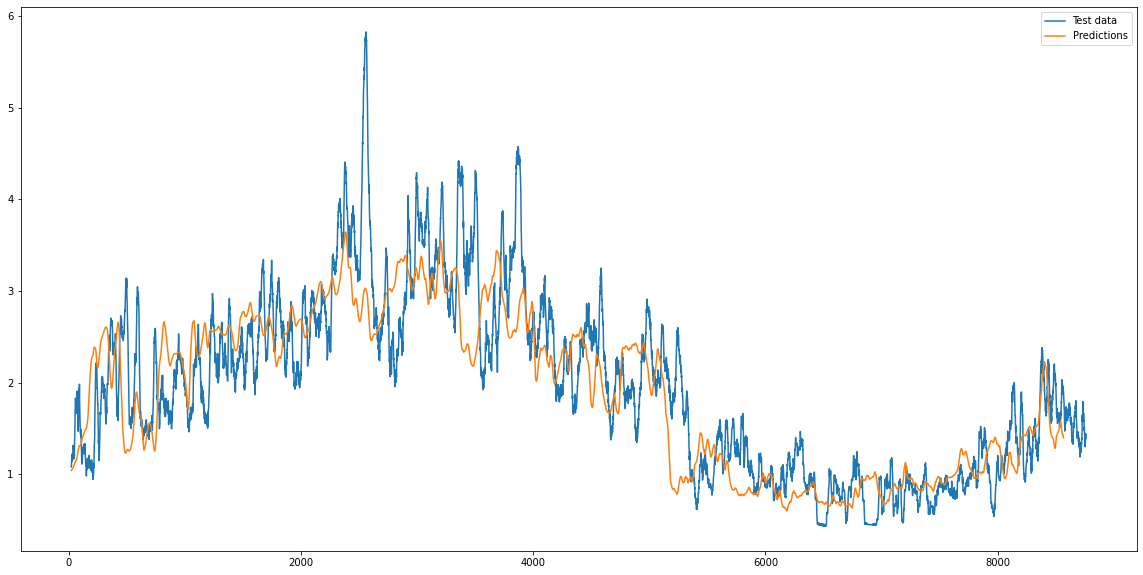

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(pd.DataFrame(scalero.inverse_transform(y_test_scaled)).rolling(24).mean(), label = 'Test data')
ax.plot(pd.DataFrame(scalero.inverse_transform(predictions_24)).rolling(24).mean(), label='Predictions')
#plt.xlim(1000, 2000) # for checking if it looks cyclic (sin)
plt.legend()
plt.show()

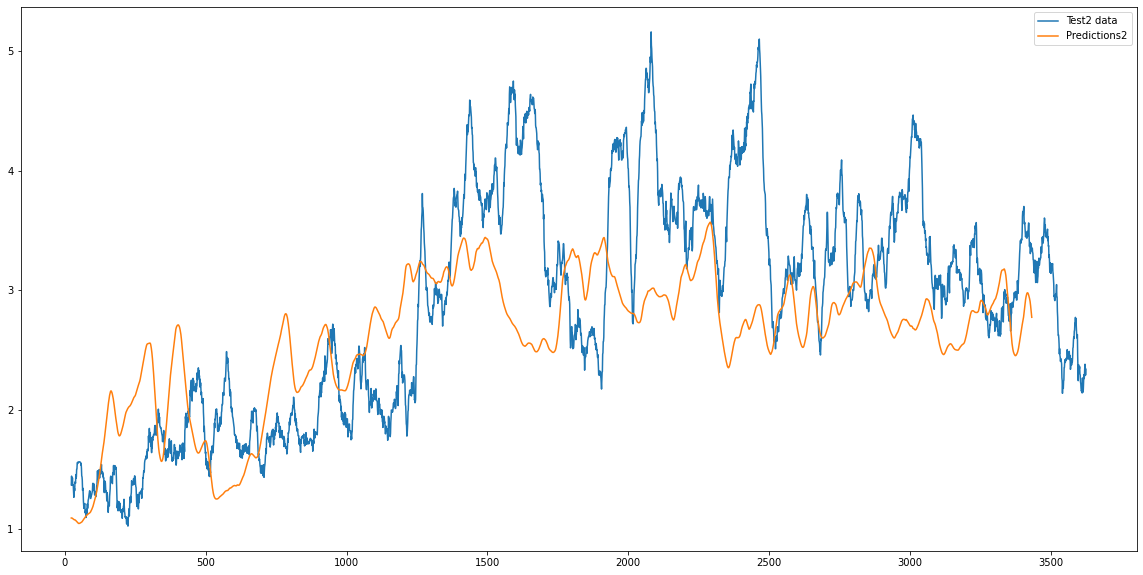

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(pd.DataFrame(scalero.inverse_transform(y_test2_scaled)).rolling(24).mean(), label = 'Test2 data')
ax.plot(pd.DataFrame(scalero.inverse_transform(predictions2_24)).rolling(24).mean(), label='Predictions2')
plt.legend()
plt.show()

# Conclusion

Write short conclusion about results, development process etc. 

The data wrangling was very time consuming, but interesting. I would have liked to have more time to spend on the models themselves and discuss them in the classroom.

The model which predicts temperature for the next hour seems to be working reasonably well. And the 24 hour prediction is not completely off, but is less acurate, as is to be expected due to the longer time span. It was good to see that also the validation date (test2) followed the expected curve.



In [ ]:
# own notes, please ignore

## split when column
# split_date_train = datetime(2020, 9, 30) + timedelta(days=1)
# split_date_test = datetime(2021, 9 ,30) + timedelta(days=1)

# df_training = df_consumption_weather.loc[df_consumption_weather['Datetime'] <= split_date_train ]
# df_test = df_consumption_weather.loc[(df_consumption_weather['Datetime'] > split_date_train) & (df_consumption_weather['Datetime'] <= split_date_test)]
# df_test2 = df_consumption_weather.loc[df_consumption_weather['Datetime'] > split_date_test]